# Process `iapp_wiki_qa` to SQuAD Format

In [250]:
from datasets import load_dataset
import json
import jsonlines
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [251]:
#load dataset
with open('iapp-thai-wikipedia-qa-1961-docs-9170-questions.json','r') as f:
    j = json.load(f)
list(j['db'].keys())[:10]

['01KZTrxgvC5mOovXFMPJ',
 '01asKzWKkocCMjZAITfL',
 '03Ezpc2OXtjeS6EVN4fi',
 '03xHGzW2DvkChsaT5dLb',
 '04BmI3HcGl4MpdzMikX1',
 '05JQW7q0XQOZwbsAocxt',
 '05Vid2v4a9EZBdOZpdVD',
 '071imckvqaBULVkHpFoe',
 '07a7HD6G4jvukeSYtkvz',
 '0D2kcaAC4m9Der4cmG7G']

In [252]:
#data is stored at context level
#some questions have more than one answer; we filter then out
article_id = 'yLfGJ35d5aLhD16TGNOV'
article = j['db'][article_id]
article

{'createOn': '2019-08-23 15:57:45.947000+00:00',
 'isPay': {'date': None, 'status': False},
 'uid': 'yLfGJ35d5aLhD16TGNOV',
 'title': 'คนกับควาย',
 'textDetector': [{'text': '', 'start': 0, 'end': 0},
  {'text': 'เป็นเพลงเพื่อชีวิตที่มีชื่อเสียงของวง', 'start': 10, 'ending': 46},
  {'text': 'วงคาราวาน', 'start': 45, 'ending': 53},
  {'text': 'สุรชัย จันทิมาธร', 'start': 66, 'ending': 81},
  {'text': 'คนกับควาย', 'start': 66, 'ending': 81},
  {'text': 'บ็อบ ไดแลน', 'start': 116, 'ending': 125},
  {'ending': 146, 'text': 'แต่งคำร้องภาษาไทยโดย', 'start': 127},
  {'start': 148, 'ending': 158, 'text': 'สมคิด สิงสง'},
  {'text': 'ได้แสดงสู่สาธารณะเป็นครั้งแรก โดย', 'start': 491, 'ending': 523},
  {'start': 524, 'ending': 539, 'text': 'สุรชัย จันทิมาธร'},
  {'start': 544, 'ending': 554, 'text': 'วิสา คัญทัพ'}],
 'detail': 'คนกับควาย เป็นเพลงเพื่อชีวิตที่มีชื่อเสียงของวงคาราวาน ขับร้องโดย สุรชัย จันทิมาธร จากทำนองเพลง "Master of War" ของ บ็อบ ไดแลน แต่งคำร้องภาษาไทยโดย สมคิด สิงสง\n\nได้ฟังเพล

In [253]:
#extract questions that have only one, non-empty answer
db = j['db']

reses = []
for article_id in tqdm(list(db.keys())):
    article = db[article_id]
    context = article.get('detail',False)
    #check if article exists
    if not context: continue
    qas = article['QA']
    textdetectors = article['textDetector']
    #generate dict
    textdetectors_d ={}
    for t in textdetectors:
        textdetectors_d[t['text']] = {'answer_start': t.get('start'), 'answer_end':t.get('ending', False) or t.get('end')}
    #append instance to reses
    for i in range(len(qas)):
        qa = qas[i]
        #keep only single answer questions
        if len(qa['a'])>1: continue
        #keep only non-empty questions and answers
        if (len(qa['q'])==0) or (len(qa['a'])==0): continue
        res = {
            'article_id': article_id,
            'question_id': f'{article_id}_{str(i).zfill(3)}',
            'context': context,
            'question': qa['q'],
            'answers': {
                'text': qa['a'],
                'answer_start': [textdetectors_d[qa['a'][0]]['answer_start']],
                'answer_end': [textdetectors_d[qa['a'][0]]['answer_end']+1]
            },
            'title': article['title'],
            'created_by': article['createBy'],
            'created_on': article['createOn'],
            'is_pay': article['isPay']
        }
        reses.append(res)

((array([4189.,    0.,    8.,    0.,   89.,    0.,  167.,    0.,  231.,
         3246.]),
  array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ]),
  <a list of 10 Patch objects>),
 8920.5)

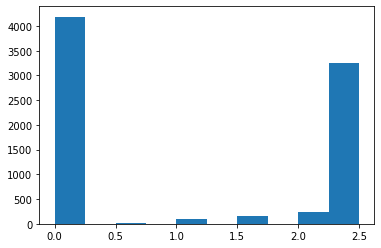

In [254]:
# costs for constructing dataset
totals = []
for res in reses:
    if res['is_pay']['status']:
        totals.append(res['is_pay']['total'])
    else:
        totals.append(0)
plt.hist(totals), sum(totals)

In [255]:
#clean out answers whose text detection indices do not match the text
cleaned_reses = []
for res in tqdm(reses):
    #text answer
    answer_text = res['answers']['text'][0]
    #extracted answer
    start_idx = res['answers']['answer_start'][0]
    end_idx = res['answers']['answer_end'][0]
    answer_extracted = res['context'][start_idx:end_idx]
    if answer_text==answer_extracted:
        cleaned_reses.append(res)
#     else:
#         new_start_idx = res['context'].index(res['answers']['text'])
#         new_end_idx = new_start_idx + len(res['answers']['text'])
#         res['answers']['answer_start'] = [new_start_idx]
#         res['answers']['answer_end'] = [new_end_idx]
    else:
        print(f"Question: {res['question']}")
        print(f'Answer: {answer_text}|{answer_extracted}')
        print('--------------------------------')

Question: สมคิด พงษ์อยู่เริ่มเรียนฟันดาบตั้งแต่อายุเท่าไหร่
Answer: 13 ปี|ปี ซึ
--------------------------------
Question: ทำไมสมคิด พงษ์อยู่ถึงให้ถูกออกจากการการแข่งขันของเยอรมัน
Answer: สถานะชาวไทย|นะชาวไทย ส่
--------------------------------
Question: สมคิด พงษ์อยู่ได้รับรางวัลเหรียญทองจากการแข่งขันเอเชียนเกมส์ปีไหน
Answer: 1998 ที่กรุงเทพมหานคร|8 ที่กรุงเทพมหานคร ก่
--------------------------------
Question: อะบู อัลวาฟา บัซจานีมีผลงานโดดเด่นด้านคณิตศาสตร์เรื่องอะไร
Answer: ตรีโกณมิติ เช่น ค้นพบเอกลักษณ์ตรีโกณมิติหลายข้อ ค้นพบกฎของไซน์ แนะนำการใช้ฟังก์ชันแทนและคิดค้นวิธีใหม่ในการสร้างตารางค่าไซน์และแทน|โกณมิติ เช่น ค้นพบเอกลักษณ์ตรีโกณมิติหลายข้อ ค้นพบกฎของไซน์ แนะนำการใช้ฟังก์ชันแทนและคิดค้นวิธีใหม่ในการสร้างตารางค่าไซน์และแทน ใน
--------------------------------
Question: ตัวละครหลักในเรื่องเคโรโระ ขบวนการอ๊บอ๊บป่วนโลกมีตัวอะไรบ้าง
Answer: สิบโทเคโรโระ
แองโกล โมอา
พลทหารทามามะ
สิบตรีกิโรโระ
สิบเอกคูรุรุ
สิบจัตวาโดโรโระ
ฮินาตะ ฟูยูกิ
ฮินาตะ นัทสึมิ|รโระ
แองโกล โมอา
พลทหารทามามะ
สิบ

--------------------------------
Question: มีคุณสมบัติอะไรบ้าง
Answer: ประเภทกระจกตกแต่งภายใน กระจกลามิเนตลายผ้า-กระดาษ สีหลัก (สีพื้น)สีแดง|กระจกลามิเนตลายผ้า-กระดาษ สีหลัก (สีพื้น)สีแดง
ราคา 1 ตารางฟุตขึ้นไป 
--------------------------------
Question: จุดประสงค์ของประตูพระจันทร์ใช้เพื่อทำอะไรอะไร
Answer: จุดประสงค์ของประตูนี้ใช้เพื่อเชื้อเชิญชนชั้นสูงหรือผู้มีฐานดีให้เข้าเยี่ยมชมสวน|ุดประสงค์ของประตูนี้ใช้เพื่อเชื้อเชิญชนชั้นสูงหรือผู้มีฐานดีให้เข้าเยี่ยมชมสวน 
--------------------------------
Question: รูปทรงกลมเหมือนพระจันทร์ของประตูเป็นสัญลักษณ์ของความสมบูรณ์แบบอ้างมาจากคำกล่าวใด
Answer: ดอกไม้สวยงามเมื่อพระจันทร์เต็มดวง หรือสิ่งที่เป็นความสุขในชีวิต จากอีกคำกล่าวที่ว่า “มนุษย์มีทั้งสุขและทุกข์ พบเจอและพลัดพราก พระจันทร์ส่องสว่างและริบหรี่ ลอยขึ้นหรือลง|อกไม้สวยงามเมื่อพระจันทร์เต็มดวง หรือสิ่งที่เป็นความสุขในชีวิต จากอีกคำกล่าวที่ว่า “มนุษย์มีทั้งสุขและทุกข์ พบเจอและพลัดพราก พระจันทร์ส่องสว่างและริบหรี่ ลอยขึ้นหรือลง”
--------------------------------
Question: ประตูพระจันทร์แบบจี

In [256]:
#those that do not match indices are quite dirty so we excluded 56 questions (7930-7874)
len(cleaned_reses), len(reses)

(7874, 7930)

In [257]:
#for extractive qa, we only keep answers 100 characters and below
extractive_reses = []
text_lens = []
for res in cleaned_reses:
    text_len = len(res['answers']['text'][0])
    text_lens.append(text_len)
    if text_len>100: 
        print(f"Question: {res['question']}")
        print(f"Answer: {res['answers']['text'][0]}")
        print('--------------------------------')
    else:
        extractive_reses.append(res)

Question: ประเทศออสเตรเลียอยู่ติดกับประเทศอะไรบ้าง
Answer: ประเทศเพื่อนบ้านของออสเตรเลียประกอบด้วย อินโดนีเซีย ปาปัวนิวกินีและติมอร์-เลสเตทางเหนือ หมู่เกาะโซโลมอน วานูอาตู และนิวแคลิโดเนียทางตะวันออกเฉียงเหนือ และนิวซีแลนด์ทางตะวันออกเฉียงใต้
--------------------------------
Question: พระราชวังเซนต์เจมส์เดิมที่คืออะไร
Answer: โรงพยาบาลคนโรคเรื้อนที่อุทิศให้แก่นักบุญเจมส์ ลูกของอัลเฟียส ซึ่งเป็นชื่อที่พระราชวังและอุทยานตั้งตาม
--------------------------------
Question: ต้นเกดเป็นต้นไม้ลักษณะใด และมีความสูงของต้นเท่าใด
Answer: ต้นไม้ขนาดกลางถึงขนาดใหญ่ มีน้ำยางขาว สูง 15-25 เมตร เรือนยอดแน่นทึบเป็นพุ่มกลม ลำต้น และกิ่งมักคดงอ เปลือกนอกสีน้ำตาลอมเทาหรือสีคล้ำ แตกเป็นสะเก็ดสี่เหลี่ยมหรือแตกเป็นร่องลึกตามยาว เปลือกในสีแดงอมน้ำตาลหรือชมพู ใบเดี่ยว
--------------------------------
Question: ลักษณะการแบ่งกลีบเลี้ยงของต้นเกดเป็นอย่างไร อธิบาย
Answer: กลีบเลี้ยง 6 กลีบ เรียงเป็น 2 วง วงละ 3 กลีบ กลีบดอกโคนติดกันเป็นหลอดสั้น ๆ ปลายแยกเป็นแฉกรูปใบหอก 6 แฉก เกสรเพศผู้สมบูรณ์และไม่สมบูรณ์อย่างละ 6 อ

Answer: มีลำตัวป้อมสั้นเกือบกลม ด้านข้างแบน ดูคล้ายใบโพ อันเป็นที่มาของชื่อเรียก สันหลังโค้งนูน หัวค่อนข้างใหญ่ จะงอยปากสั้น นัยน์ตาโต บริเวณระหว่างตาโค้งนูนออกมา ปากเล็กและยืดหดได้ มีฟันเล็กและแหลมคมบนขากรรไกรบนและล่าง ลำตัวด้านบนสีขาวปนเทาและมีจุดเล็ก ๆ สีส้มเรียงเป็นแถวขวางลำตัวจำนวน 4-11 แถว ซึ่งแตกต่างจากปลาใบโพจุด (D. punctata) ที่มีแถบสีเทาเรียงในลักษณะเดียวกัน ปลาวัยอ่อนจะมีแถบสีดำในบริเวณที่เป็นจุดสีส้ม
--------------------------------
Question: อาสวกิเลสประกอบด้วยอะไรบ้าง
Answer: กาม ได้แก่ ความติดใจรักใคร่อยู่ในกามคุณ
ภพ ได้แก่ ความติดอยู่ในภพ ความอยากเป็นโน่นเป็นนี่
ทิฏฐิ ได้แก่ ความเห็นผิด ความหัวดื้อหัวรั้น
อวิชชา ได้แก่ ความไม่รู้จริง ความลุ่มหลงมัวเมา
--------------------------------
Question: ต้นมะเกลือมีลักษณะทางพฤษศาสตร์เป็นอย่างไรอธิบาย
Answer: ไม้ต้นขนาดกลางถึงขนาดใหญ่ สูง 10-30 เมตร เรือนยอดเป็นพุ่มกลม ลำต้นเปลา โคนต้นมักเป็นพูพอน ผิวเปลือกเป็นรอยแตกสะเก็ดเล็กๆ สีดำ เปลือกในสีเหลือง กระพี้สีขาว กิ่งอ่อนมีขนนุ่มขึ้นประปราย ใบ เป็นใบเดี่ยวขนาดเล็กรูปไข่หรือรีเรียงตั

Question: ปลาบู่เขือคางยื่นมีรูปร่างคล้ายอะไร อธิบายลักษณะพอความเข้าใจ
Answer: มีรูปร่างยาวคล้ายงู หัวเหมือนปลาบู่ทั่วไป แต่หน้าหัก คางยื่นออกมาเล็กน้อย ปากกว้าง มีฟันเป็นซี่แหลมขนาดเล็กในปาก ใต้ปากล่างมีติ่งเนื้อยื่นออกมาโดยรอบ ตามีขนาดเล็กมาก ครีบอกมีขนาดใหญ่ ครีบหลัง ครีบก้นไม่ต่อเนื่องกับครีบก้น ลำตัวลื่นมาก มีเกล็ดขนาดเล็กละเอียด พื้นสีลำตัวเป็นสีชมพูหรือเหลืองเหลือบทองในบางตัว
--------------------------------
Question: ต้นมณฑามีลักษณะพรรณไม้เป็นอย่างไร จงอธิบาย
Answer: ลักษณะเป็นไม้พุ่มสูงประมาณ 1-3 เมตร ใบเป็นใบเดี่ยวออกสลับรูปรี ปลายใบแหลม ขอบใบหยักหรือเป็นคลื่นเล็กน้อย ดอกออกตามซอกใบ มีกลีบเลี้ยงหนาสีเขียวอมเหลือง 3 กลีบ กลีบดอกสีเหลืองอ่อน 6 กลีบ เรียงเป็นชั้น ชั้นละ 3 กลีบ กลีบดอกเป็นรูปไข่กลับ ดอกมีกลิ่นหอมแรง
--------------------------------
Question: เอ๋อเหรอ ซึ่งเนื้อเรื่องในภาพยนตร์เป็นยังไง
Answer: การผจญภัยของ ต๋อง กับ ลูกแก้ว ซึ่งห่างจากพ่อแม่ของเขา โดยถูกคนร้ายถูกจับมาเพื่อที่จะมาขายผลไม้ในเมืองพัทยา
--------------------------------
Question: รายละเอียดของสินค้า
Ans

Answer: ช้องนาง เป็นไม้พุ่มเล็ก แตกกิ่งก้านมาก สูงประมาณ 6 ฟุต ใบคล้ายใบแก้ว ใบมนปลายแหลมยาวประมาณ 3 นิ้ว ออกเป็นคู่ ๆ ตามกิ่ง ดอกเป็นรูปแตร ปลายดอกผายออกเป็น 5 แฉก ในดอกตรงกลางมีตาสีเหลือง ดอกสีม่วง และยังมีชนิดดอกสีขาวเรียกว่าช้องนางขาว ดอกยาวประมาณ 2 นิ้ว
--------------------------------
Question: ลักษณะของตานดำเป็นอย่างไร
Answer: เป็นไม้ยืนต้น สูงได้ถึง 15 เมตร ลำต้นและกิ่งมีหนาม ใบเป็นใบเดี่ยวเรียงสลับ รูปไข่กลับถึงรูปรี ยาว 2-12 เซนติเมตร ปลายใบเรียวแหลม โคนใบเว้าคล้ายรูปหัวใจ แผ่นใบมีขนสั้นนุ่มทั้งสองด้าน ดอกแยกเพศอยู่ต่างต้น ดอกเพศผู้
--------------------------------
Question: รายละเอียดของสินค้า
Answer: ใช้สำหรับงานตกแต่งภายในทั่วไป กั้นห้อง หรือ แบ่งพื้นที่ภายในห้องออกจากกัน รวมทั้ง หน้าบานตู้ ประตู และหน้าต่าง
--------------------------------
Question: กรมอู่ทหารเรือมีส่วนราชการอะไรบ้าง
Answer: กองบังคับการ
กรมแผนการช่าง
กรมพัฒนาการช่าง
อู่ทหารเรือธนบุรี
อู่ทหารเรือพระจุลจอมเกล้า
อู่ราชนาวีมหิดลอดุลยเดช
ศูนย์พัสดุช่าง
--------------------------------
Question: มีวิธีการกำจัด

Answer: กองทัพเคโรน (ЯOЖOR) ได้เตรียมการยึดครองโลกมนุษย์ด้วยกำลังทหารแต่ในปฏิบัติการวันแรก สิบโทเคโรโระซึ่งเป็นหัวหน้ากองร้อยเคโรโระที่เข้ามาแทรกซึมบนโลกเป็นแนวหน้าได้ถูกพี่น้องฮินาตะจับตัวได้โดยบังเอิญ เมื่อกองทัพหลักทราบเรื่องจึงถอยทัพกลับ และสั่งให้พวกเคโรโระปฏิบัติการยึดครองโลกไปตามลำพัง พวกเคโรโระได้ดำเนินการสารพัดวิธี เพื่อหาทางยึดครองเพโคปอง (ชื่อดาวโลกที่มนุษย์ต่างดาวในเรื่องเรียก ในฉบับอนิเมะเปลี่ยนชื่อมาเป็นเพโคปอง) แม้ว่าทุกครั้งจะประสบความล้มเหลวเพราะนิสัยของตัวเคโรโระเองก็ตาม ขณะเดียวกันก็ต้องปกป้องโลกจากอันตราย และมนุษย์ต่างดาวกลุ่มอื่นด้วย
--------------------------------
Question: ตัวละครในเรื่องเคโรโระ ขบวนการอ๊บอ๊บป่วนโลกใช้ไอเท็มอะไรบ้าง
Answer: เคโระบอล - อุปกรณ์ลักษณะคล้ายลูกบอลสีดำ สามารถเนรมิตรทำอะไรได้ทุกอย่าง จำเป็นอย่างมากสำหรับหัวหน้าทีม
หมวกกองทัพดาวเคโรน - หมวกธรรมดา แต่พิเศษตรงที่มีแอนตี้บาเรีย ป้องกันไม่ให้มนุษย์โลกเห็น (ยกเว้น คนในบ้านฮินาตะ ที่สามารถมองเห็นได้ และสามารถเลือกได้ว่าให้ใครเห็นได้อีกด้วย)
ปืนถ้าชีวิตมีสองครั้ง - ปืนที่ประดิษฐ์โดยคูรุรุ เป็น

Answer:  ไม่พุ่ม สูง 2-4 เมตร กิ่งอ่อนมีหนาม ใบประกอบชนิดมีใบย่อยใบเดียว เรียงสลับ รูปไข่ รูปวงรีหรือรูปไข่แกมขอบขนานกว้าง 3-5 ซม. ยาว 4-8 ซม. เนื้อใบมีจุดน้ำมันกระจาย ก้านใบมีครีบเล็ก ๆ ดอกเดี่ยวหรือช่อ ออกที่ปลายกิ่งและที่ซอกใบ กลีบดอกสีขาว กลิ่นหอม ร่วงง่าย ผลเป็นผลสด กลมเกลี้ยง ฉ่ำน้ำ
--------------------------------
Question: ต้นกระเทียมมีคุณสมบัติทางยาสมุนไพรอย่างไรบ้าง จงอธิบาย
Answer: ประโยชน์ทางสมุนไพร :  ตำรายาไทยใช้น้ำมะนาวและผลดองแห้งเป็นยาขับเสมหะแก้ไอ แก้โรคเลือดออกตามไรฟัน เพราะมีวิตามินซี น้ำมะนาวเป็นกระสายยาสำหรับสมุนไพรที่ใช้ขับเสมหะเช่นดีปลี
--------------------------------
Question: ภาพ “การเต้นรำที่มูแล็งเดอลากาแล็ต” เป็นภาพเขียนอย่างไร ?
Answer: เป็นภาพบรรยากาศบ่ายวันอาทิตย์ที่พบทั่วไปที่มูแล็งเดอลากาแล็ตในเขตมงมาทร์ในปารีส บ่ายวันอาทิตย์ในตอนปลายคริสต์ศตวรรษที่ 19 ชนชั้นแรงงานในปารีสนิยมแต่งตัวกันอย่างสวยงามเพื่อออกไปสังสรรค์ เต้นรำ กินของหวาน (galette) กันจนค่ำ


--------------------------------
Question: โลมาแม่น้ำโบลิเวียต่างกับโลมาแม่น้ำอเมซอนอย่างไร
Answer: 

Answer: กระจกทีให้ความปลอดภัยสูง เมื่อแตกกระจกจะไม่หลุดออกมา เนืองจากมีฟิล์มยึดเกาะกระจกกับเนื้อผ้า เหมาะสำหรับตกแต่งภายในอาคาร ให้ความสวยงาม หรูหรา มีเอกลักษณ์เฉพาะตัวที่โดดเด่น
--------------------------------
Question: รายละเอียดของสินค้า
Answer: ใช้สำหรับงานตกแต่งภายในทั่วไป กั้นห้อง หรือ แบ่งพื้นที่ภายในห้องออกจากกัน รวมทั้ง หน้าบานตู้ ประตู และหน้าต่าง
--------------------------------
Question: เกิดอะไรขึ้นกับณัฐพงษ์ ขจรมาลีเมื่อวันที่ 30 เมษายน พ.ศ. 2560
Answer: เขาได้ประสบอุบัติเหตุ รถยนต์ที่เขานั่งได้ชนกับรถบรรทุกอย่างจัง ซึ่งเขาอาการสาหัส และได้รับการนำตัวส่งโรงพยาบาล
--------------------------------
Question: ปลาแค้ขี้หมูเป็นปลาที่มีลักษณะเป็นรูปแบบใด อธิบาย
Answer: มีลักษณะลำตัวเล็ก ด้านท้ายเรียวและแบนข้าง หัวโต ปากมนอยู่ด้านล่าง มีหนวด 4 คู่ ตาเล็กและยกสูง ครีบหลังยกสูง ก้านครีบอกโค้งยาวและมีหยักทั้งด้านหน้าและขอบท้าย ครีบหางเว้าโค้ง ลำตัวสีเทาอมเหลืองหรือน้ำตาลและมีประสีคล้ำ ครีบใสและมีแต้มสีคล้ำ
--------------------------------
Question: ปลาแค้ขี้หมูมีถิ่นที่อยู่อาศัยอยู

Answer: การก่อสร้างและระบบการขนส่ง รวมทั้ง เสียงรบกวนจากพาหนะยานยนต์, เครื่องบิน และรถไฟ หรือแม้แต่การวางผังเมืองที่ไม่ดีอาจก่อให้เกิดมลพิษทางเสียงได้เช่นกัน และทางด้านแหล่งอุตสาหกรรมข้างเคียง ตลอดจนการปลูกสร้างที่อยู่อาศัยก็อาจก่อให้เกิดมลพิษทางเสียงในพื้นที่บริเวณที่อยู่อาศัยได้
--------------------------------
Question: แกร์ฮาร์ท โดมัคได้รับรางวัลโนเบลสาขาอะไร
Answer: สาขาสรีรวิทยาหรือการแพทย์ในปี ค.ศ. 1939 แต่รัฐบาลนาซีกดดันให้โดมัคปฏิเสธรางวัลและถูกคุมตัวนานกว่าสัปดาห์ จนในปี ค.ศ. 1947 โดมัคจึงได้รับรางวัลโนเบล ผลงานของโดมัคช่วยในการพัฒนายาต้านวัณโรคในยุโรปช่วงสงครามโลกครั้งที่สอง
--------------------------------
Question: เทือกเขาแอเพนไนน์มีภูเขาส่วนใหญ่เป็นลักษณะอย่างไร
Answer: ส่วนใหญ่มีสีเขียวและเต็มไปด้วยป่าเขาลำนาไพร ถึงแม้ว่ายอดสูงสุดของเทือกเขานี้ กอร์โนกรันเด (2,912 ม.) ปกคลุมไปด้วยธารน้ำแข็งที่อยู่ใต้สุดของทวีปยุโรป ส่วนลาดเอียงของเทือกเขาทางตะวันออกของประเทศอิตาลีไปจนถึงทะเลเอเดรียติกลาดชันมาก ขณะที่ส่วนลาดเอียงของเทือกเขาทางตะวันตกทำให้เกิดที่ราบซึ่งเป็นที่ที่เมืองทางป

Answer: อดีต ผู้บัญชาการทหารอากาศ คนที่ 10 ดำรงตำแหน่งช่วงปี 2526-2530 อดีตรองประธานวุฒิสภา คนที่ 2 และอดีตสมาชิกวุฒิสภาแบบแต่งตั้ง
--------------------------------
Question: จงอธิบายรูปร่างของปลากะพงขาววีระพงษ์มาพอความเข้าใจ
Answer: รูปร่างลำตัวหนาและด้านข้างแบน หัวโต จะงอยปากค่อนข้างยาวและแหลม นัยน์ตาโต ปากกว้างยืดหดได้ มุมปากอยู่เลยไปทางหลังนัยน์ตา ฟันเป็นฟันเขี้ยวอยู่บนขากรรไกรบนและล่าง ขอบกระดูกแก้มเป็นหนามแหลม ขอบกระดูกกระพุ้งเหงือกแข็งและคม คอดหางมีขนาดใหญ่และแข็งแรง เกล็ดใหญ่มีขอบหยักเป็นหนามเมื่อลูบจะสากมือ ครีบหลังอันแรกมีก้านครีบเป็นหนามแข็ง ปลายแหลม
--------------------------------
Question: จุดประสงค์ของวันเทคโนโลยีของไทยคืออะไร
Answer: เพื่อเป็นการแสดงความจงรักภักดี และรำลึกในพระมหากรุณาธิคุณของพระบาทสมเด็จพระเจ้าอยู่หัว ที่ทรงมีต่อพสกนิกรชาวไทยมาโดยตลอด โดยทรงศึกษาค้นคว้าวิจัย และทรงนำเทคโนโลยีสมัยใหม่ มาประยุกต์ใช้แก้ไขปัญหาความเดือดร้อนของประชาชน ตลอดจนเป็นการแสดงเทคโนโลยี ที่คิดค้นประดิษฐ์และพัฒนาโดยคนไทย เพื่อเป็นการกระตุ้น ให้สาธารณชนเกิดความเชื่อมั่นและเข้าร่วมพัฒน

Question: ต้นยอมีคุณสมบัติทางสมุนไพรอะไรบ้าง อธิบายโดยละเอียด
Answer: ประโยชน์ทางสมุนไพร :  ตำรายาไทยใช้ผลสดดิบหรือห่าม ฝานเป็นชิ้นบาง ย่างหรือคั่วไฟอ่อน ๆ ให้เหลือง ต้มหรือชงกับน้ำ ดื่มแก้คลื่นไส้อาเจียน สารที่ออกฤทธิ์คือ asperuloside
--------------------------------
Question: ใครเป็นผู้ค้นพบชมพูสิริน
Answer: ดร.ปราโมทย์ ไตรบุญ นักวิชาการเกษตรชำนาญการจากกรมวิชาการเกษตร (ในขณะสำรวจพบ) และ ดร.ปิยเกษตร สุขสถาน นักพฤกษศาสตร์จากองค์การสวนพฤกษศาสตร์ (ในขณะสำรวจพบ)
--------------------------------
Question: เมื่ออัตราส่วนของความยาวของส่วนของเส้นตรงสองเส้นเป็นจำนวนอตรรกยะเราจะเรียกว่าอะไร
Answer: เรียกส่วนของเส้นตรงทั้งสองเส้นนั้นว่าวัดไม่ได้ (incommensurable) หมายความว่า ทั้งสองเส้นไม่มีมาตรวัดเดียวกัน มาตรวัดของส่วนของเส้นตรง I ในที่นี้หมายถึงส่วนของเส้นตรง J ที่วัด I โดยวาง J แบบหัวต่อหางเป็นจำนวนเต็มจนยาวเท่ากับ I
--------------------------------
Question: ปลาบ้านั้นมีรูปร่างเป็นอย่างไรอธิบายพอความเข้าใจ
Answer: เป็นปลาที่มีขนาดใหญ่ มีรูปร่างยาว ลำตัวค่อนข้างกลม หัวโต นัยน์ตาค่อนข้างโต ปา

หลังจากปี ค.ศ. 1768 เจมส์ วัตต์ (James Watt) นักประดิษฐ์ชาวอังกฤษสามารถสร้างเครื่องจักรไอน้ำได้สำเร็จได้มีนักประดิษฐ์จำนวนมากนำเครื่องจักรไอน้ำมาใช้เป็นส่วนประกอบของเครื่องจักรชนิดต่างๆมากมาย แต่ก็ไม่ค่อยได้รับความนิยมกัน ซึ่งหนึ่งในนั้นคือริชาร์ด เทรวิทิก (Richard Trevithick) วิศวกรชาวอังกฤษที่ได้ทำการสร้างรถจักรไอน้ำเป็นผลสำเร็จ ซึ่งรถจักรไอน้ำนี้ยังเป็นล้อธรรมดาและวิ่งบนถนนอยู่ ต่อมาทางเหมืองแร่ที่จอร์จ สตีเฟนสัน (George Stephenson) ทำงานอยู่ได้นำรถจักรไอน้ำนี้มาใช้ในการขนถ่านหิน แต่รถจักรของวิชาร์ดทราวิคนั้นยังมีข้อเสียอยู่หลายอย่างทั้งเรื่องความเร็ว และยังทำความเสียหายแก่ถนนเพราะน้ำหนักการบรรทุกที่มาก จึงได้มีการสร้างรางเหล็กให้รถจักรนี้วิ่งซึ่งเป็นการกำจัดปัญหาการทำให้ถนนพัง แต่เมื่อมีการวิ่งรถบนรางแล้วรถจักรก็ยังคงตกรางอยู่บ่อย ๆ จึงได้มีการปรับปรุงล้อรถจักรเสียใหม่ จากเดิมที่เป็นล้อธรรมดาก็ให้เปลี่ยนเป็นล้อเหล็กและมีร่องสำหรับ วิ่งบนรางเหล็กอีกด้วย
--------------------------------
Question: รถจักรไอน้ำที่ประเทศไทย นำเข้่ามาใช้งานทั้งหมดมีกี่แบบ
Answer: แบบล้อของรถจักรไอน้ำโมุกล

Answer: มีรูปร่างเพรียว ลำตัวแบนข้าง ส่วนหัวสั้น ปากเล็ก ตาโตอยู่ต่ำกว่ามุมปาก ส่วนหลังไม่ยกสูง มีหนวดยาว 2 คู่ หนวดที่ริมฝีปากยาวถึงบริเวณขอบฝาปิดเหงือก หนวดใต้คางสั้น ครีบหลังเล็กมากเห็นเป็นเส้นสั้น ๆ ครีบอกใหญ่มีก้านแข็งที่ยาวเกือบเท่าความยาวของครีบ ครีบก้นยาว มีหางเว้าตื้น ตัวมีสีเหลืองอ่อนเหลือบเขียว ตัวค่อนข้างใส ครีบสีจาง ขอบครีบก้นมีสีคล้ำเช่นเดียวกับครีบหาง ครีบอกในตัวผู้ที่โตเต็มวัยมีสีคล้ำ
--------------------------------
Question: กั้งกระดานมีการกระจายสายพันธุ์ในโซนใดบ้างอธิบายพอสังเขป
Answer: กระจายพันธุ์ในแถบอินโด-แปซิฟิก, ชายฝั่งแอฟริกาตะวันออก, ทะเลแดง, ทะเลอันดามัน, ตอนใต้ของญี่ปุ่น, จีน จนถึงอ่าวมอร์ตัน ในออสเตรเลีย
--------------------------------
Question: ปลากามีรูปร่างเป็นอย่างไรจงอธิบาย
Answer: มีรูปร่างป้อม แต่หลังป่องออก ครีบหลังสูง ไม่มีก้านครีบแข็ง มีหนวดค่อนข้างยาว 2 คู่และมีติ่งเล็ก ๆ เป็นชายครุยอยู่รอบบริเวณริมฝีปาก เกล็ดเล็กมีสีแดงแซมอยู่ในแต่ละเกล็ด ครีบหางเว้าลึก ลำตัวสีดำหรือสีน้ำตาลเข้ม
--------------------------------
Question: ปลาช่อนงูเห่านั้นมีลัก

Answer: กระจกทีให้ความปลอดภัยสูง เมื่อแตกกระจกจะไม่หลุดออกมา เนืองจากมีฟิล์มยึดเกาะกระจกกับเนื้อผ้า เหมาะสำหรับตกแต่งภายในอาคาร ให้ความสวยงาม หรูหรา มีเอกลักษณ์เฉพาะตัวที่โดดเด่น
--------------------------------
Question: รายละเอียดของสินค้า
Answer: กระจกทีให้ความปลอดภัยสูง เมื่อแตกกระจกจะไม่หลุดออกมา เนืองจากมีฟิล์มยึดเกาะกระจกกับเนื้อผ้า เหมาะสำหรับตกแต่งภายในอาคาร ให้ความสวยงาม หรูหรา มีเอกลักษณ์เฉพาะตัวที่โดดเด่น
--------------------------------
Question: ปลาดุกอุยมีรูปร่างและลักษณะเป็นอย่างไร อธิบายมาพอความเข้าใจ
Answer: มีกระดูกท้ายทอยยื่นแหลมออกไปลักษณะคล้ายรูปสามเหลี่ยม ลำตัวสั้นป้อมกว่าปลาดุกด้าน (C. batrachus) ซึ่งอยู่ในสกุลเดียวกัน ลำตัวมีสีดำปนเหลือง มีจุดขาวเล็ก ๆ เรียงเป็นแถวขวางลำตัวหลายแถว มีครีบหลังสูงกว่าปลาทั่วไปมาก สามารถเคลื่อนที่บนบกได้เป็นระยะทางสั้น ๆ โดยใช้ครีบช่วย
--------------------------------
Question: ในความหมายเชิงการรักษาความปลอดภัยทางข้อมูล ข้อมูลที่ระบุตัวบุคคลได้หมายถึงอะไร
Answer: ข้อมูลที่สามารถใช้ระบุตัว ติดต่อหรือค้นหาบุคคลหนึ่งบุคคลใดโดยเฉพาะ หร

Answer: สูง 61 เมตรเหนือตัวเมืองและส่องไปตอนกลางคืน[3] ภายในเป็นซุ้มโค้งและร้านค้าขายสำหรับลูกค้าระดับสูง กระจายออกไปจากจัตุรัสก็เป็นบริเวณอื่น ๆ ของเมือง ฮอกลีย์ควอเตอร์เป็นบริเวณร้านค้าย่อยและโรงภาพยนตร์ที่อยู่ทางตะวันออกของเมือง ฮอกลีย์อยู่ติดกับเลซมาร์เก็ตซึ่งมีตึกสมัยวิกตอเรียใหญ่ ๆ และเคยเป็นบริเวณอุตสาหกรรมการทำลูกไม้ในสมัยวิกตอเรีย ทางด้านใต้ของจัตุรัสนำไปสู่บริเวณที่สร้างใหม่ศูนย์การค้าบรอดมาร์ช เลยไปจากนั้นก็เป็นคลองที่เต็มไปด้วยคาเฟและภัตตาคาร ทางด้านตะวันตกเป็นที่ตั้งของปราสาทนอตทิงแฮมและเมดมาเรียนเวย์ซึ่งเป็นบริเวณที่มีสิ่งก่อสร้างสูง ๆ จากทางด้านเหนือจากจัตุรัสเป็นศูนย์การค้าวิคตอเรียซึ่งมีทั้งร้านค้า โรงภาพยนตร์ และภัตตาคาร สถานที่ทางวัฒนธรรมก็ได้แก่โรงละครหลวง
--------------------------------
Question: การเคหะแห่งชาติ ทำไมถึงสร้างขึ้นมาองค์กรนี้
Answer: สืบเนื่องจากปัญหาที่อยู่อาศัยสำหรับผู้มีรายได้น้อยในประเทศไทย ช่วงหลังสงครามโลกครั้งที่ 2 รัฐบาลจึงได้จัดตั้งกองเคหสถาน กรมประชาสงเคราะห์ ขึ้น
--------------------------------
Question: ต้นยี่หุบมีลักษณะทางพรรณไม้อย่างไร

Question: ต้นกานพลูมีสรรพคุณทางสมุนไพรช่วยทางด้านไหนบ้างอธิบาย
Answer: ประโยชน์ทางสมุนไพร :  ตำรายาไทย ใช้ดอกตูมแห้งแก้ปวดฟัน โดยใช้ดอกแช่เหล้าเอาสำลีชุบอุดรูฟัน และใช้ขนาด 5-8 ดอก ชงน้ำเดือด ดื่มเฉพาะส่วนน้ำหรือใช้เคี้ยวแก้ท้องเสีย ขับลม แก้ท้องอืดเฟ้อ  นอกจากนี้ใช้ผสมในยาอมบ้วนปากดับกลิ่นปาก พบว่าในน้ำมันหอมรเหยที่กลั่นจากดอกมีสาร eugenol ซึ่งมีฤทธิ์เป็นยาชาเฉพาะที่ จึงใช้แก้ปวดฟัน และมีฤทธิ์ลดการบีบตัวของลำไส้ ทำให้เกิดอาการปวดท้องลดลง ช่วยขับน้ำดี ลดอาการจุกเสียดที่เกิดจากการย่อยไม่สมบูรณ์ และสามารถฆ่าเชื้อแบคทีเรียหลายชนิดเช่น เชื้อโรคไทฟอยด์ บิดชนิดไม่มีตัว เชื้อหนองเป็นต้น นอกจากนี้ยังกระตุ้นให้มีการหลั่งเมือก และลดการเป็นกรดในกระเพาะอาหารด้วย
--------------------------------
Question: กล้วยน้ำว้ามีลักษณะทางพรรณไม้อย่างไรอธิบาย โดยละเอียด
Answer: ไม้ล้มลุก สูง 2-4.5 เมตร มีลำต้นใต้ดิน ลำต้นเหนือดินเกิดจากกาบใบหุ้มซ้อนกัน ใบ  เดี่ยว เรียงสลับซ้อนกันรอบต้นที่ปลายยอด รูปขอบขนาน กว้าง 25-40 ซม. ยาว 1-2 เมตร ผิวใบเรียบมัน ท้องใบสีอ่อนกว่า มีนวล ดอก  ช่อเรียกว่า หัวปลีออกที่ปลายยอด ใบ

Question: จงอธิบายรูปร่างของชนิดปลาตุมมาพอความเข้าใจ
Answer: รูปร่างเหมือนปลากระมังชนิดอื่น ๆ เว้นแต่ก้านครีบก้นไม่มีรอยหยัก เกล็ดเล็กกว่า และลำตัวมีรอยขีดสีคล้ำตามขวางประมาณ 7-8 รอย
--------------------------------
Question: เอเดกโกมีเครือข่ายใหญ่แค่ไหน
Answer: ผู้จัดหาคำปรึกษาการบริหารทรัพยากรบุคคล (human resources solutions) รายใหญ่สุดของโลก มีลูกจ้าง 33,000 คน เครือข่ายกว่า 5,500 สาขา ในกว่า 60 ประเทศและดินแดนทั่วโลก บริษัทฯ เสนอบริการหลากหลายซึ่งเชื่อมโยงผู้เข้าร่วมกว่า 700,000 คนกับลูกค้ากว่า 100,000 คนทุกวัน บริษัทฯ
--------------------------------
Question: รายละเอียดของสินค้า
Answer: เป็นกระจกลามิเนตผนวกเข้ากับกระดาษสาโบราณ หรือที่เรียกว่า  Washi  ทำให้เกิดลวดลายจากศิลปะทำมือบนกระจกอย่างที่ไม่เคยเกิดขึ้นมาก่อน  เป็นการผสมผสานลวดลายจากความงามของธรรมชาติแบบดั้งเดิมของญี่ปุ่นเข้ากับเทคโนโลยีที่ทันสมัย  และพร้อมที่จะสะท้อนออกสู่งานดีไซน์ได้ทุกรูปแบบตามความต้องการ
--------------------------------
Question: ที่ตั้งของวัดเขาพนมเพลิง
Answer: วัดเขาพนมเพลิง เป็นโบราณสถานที่ตั้งอยู่ใน อ

--------------------------------
Question: อธิบายรูปร่างของปลากะพงลายมาพอความเข้าใจ
Answer: สีของลำตัวออกขาวเหลือบเงินและเขียวแวววาว ลายแถบสีดำบนลำตัวมีขนาดเรียวเล็ก ลายแถบตรงข้อหางแถบสุดท้ายเป็นขีดขาดกันแลดูคล้ายจุดสองขีด
--------------------------------
Question: ปลากัดหัวโม่งจันทบุรีมีรูปร่างเป็นอย่างไีรอธิบายพอความเข้าใจ
Answer: มีรูปร่างคล้ายปลากัดภูเขา (B. pugnax) ซึ่งเป็นปลากัดจำพวกอมไข่ (Mouthbrooder) เหมือนกัน ปลากัดหัวโม่งมีตัวโต ปลายปากแหลม ครีบทุกครีบใสโปร่งแสง ลำตัวสีเขียวอ่อน มีแถบสีดำพาดตามความยาวลำตัว 3 แถบ ตากลมโตสีเหลือง
--------------------------------
Question: ประตูพระจันทร์คืออะไร
Answer: ประตูพระจันทร์คือทางเปิดโล่งลักษณะวงกลมซึ่งเชื่อมต่อจากผนังหรือกำแพงที่ล้อมรอบสวน เป็นส่วนหนึ่งของสถาปัตยกรรมในสวนจีน ประตูพระจันทร์มีความหมายทางจิตวิญญาณหลากหลายแบบแตกต่างกันไปในแต่ละส่วน
--------------------------------
Question: เนื้อหาของเพลงสวิทซ์ที่ใจเกี่ยวกับอะไร
Answer: เป็นเรื่องราวของคนสองคนที่ตกอยู่ในอารมณ์เดียวกัน มีเหตุการณ์เกิดขึ้นกับชีวิตคล้ายๆ กันหลังจากถูกคนรักทิ

Answer: โดมนิเตอร์ อเล็กซานเดอร์ จอห์น คูซา องค์อธิปัตย์แห่งโรมาเนียทรงถูกรัฐประหารยึดพระราชอำนาจ จากการที่จักรวรรดิออตโตมันพ่ายแพ้ในสงครามรัสเซีย-ตุรกี
--------------------------------
Question: ปลาทรงเครื่องมีรูปร่างลักษณะคล้ายกับปลาชนิดใดอธิบาย
Answer: มีรูปร่างคล้ายปลากา (Labeo chrysophekadion) ซึ่งเป็นปลาในวงศ์เดียวกัน แต่มีรูปร่างที่เพรียวยาว มีขนาดเล็กกว่ามาก สีลำตัวสีแดงอ่อน ครีบหางสีแดงเข้ม
--------------------------------
Question: ปลาจิ้มฟันจระเข้ยักษ์มีรูปร่างลักษณะเป็นอย่างไร อธิบาย
Answer: มีรูปร่างเรียวยาวคล้ายกิ่งไม้ สัณฐานเป็นเหลี่ยม เกล็ดได้เปลี่ยนรูปกลายเป็น แผ่นกระดูกแข็ง เป็นข้อรอบตัว จะงอยปากยื่นแหลม ปลายปากคล้ายปากแตร ไม่มีฟัน ใช้ปากดูดอาหาร ลำตัวมีสีน้ำตาลเขียว และมีลายดำเป็นวงทั่วตัว ว่ายน้ำเชื่องช้า
--------------------------------
Question: ต้นจำปาเทศมีลักษณะเป็นแบบไหน อธิบาย
Answer: ไม้ยืนต้นขนาดกลางในสกุลกะหนานปลิง เปลือกลำต้นสีเทาแตกเป็นร่องเป็นสะเก็ดบิดเวียนตามยาว โคนลำต้นมักเป็นปุ่มเป็นโพรง แตกกิ่งจำนวนมาก กิ่งอ่อนยาว ปลายกิ่งห้อยลู่ กิ่งและก้านใบมีขนสีน

Answer: เจ้าชายเทวพรตได้ให้สัตย์สาบานแก่ฟ้าดินว่าจะไม่ยุ่งเกี่ยวกับบัลลังก์กษัตริย์และจะไม่แต่งงานมีลูกกับหญิงคนใด
--------------------------------
Question: ท้าวศานตนุให้พรกับท้าวภีษมะว่าอะไร
Answer: ให้พรกับภีษมะว่าจะให้ภีษมะมีอายุยืนยาวเท่าไรก็ได้ ไม่มีวันตาย นอกเสียจากว่าภีษมะจะต้องการตายเองจริง ๆ
--------------------------------
Question: ปลาค้อถ้ำพระวังแดงมีรูปร่างเป็นอย่างไร อธิบาย
Answer: ลักษณะลำตัวค่อนข้างป้อม สีเนื้ออมชมพูและเหลืองอ่อน ครีบมีสีใสสีเหลืองเรื่อ ๆ ตัวผู้มีส่วนหลังโค้งนูน รูจมูกมีติ่งแหลมคล้ายหนวด ตาลดขนาดเล็กจนมีขนาดเล็กมากจนเป็นจุดเล็ก ๆ 
--------------------------------
Question: ปลาค้อถ้ำพระวังแดงถูกค้นพบที่ใด อธิบาย
Answer: พบที่เฉพาะในถ้ำพระวังแดง ในอุทยานแห่งชาติทุ่งแสลงหลวง จังหวัดพิษณุโลก โดยอยู่ลึกเข้าไปตั้งแต่ 100 เมตรขึ้นไป
--------------------------------
Question: อธิบายรูปร่างของปลาซิวเจ้าฟ้ามาพอความเข้าใจ
Answer: มีสีโปร่งใส เห็นแกนดำของกระดูกสันหลังชัดเจน ตาโต หลังค่อม ท้องเป็นสีเงินแวววาว บริเวณส่วนหัวด้านบนมีสีเขียวเหลือบทอง
------------------

Answer: นักร้องแจ๊สและป๊อปชาวอเมริกัน มีประสบการณ์การแสดงคอนเสิร์ตมากกว่า 300 ครั้งทั่วสหรัฐอเมริกา ญี่ปุ่น ไทย และเกาหลีใต้
--------------------------------
Question: ถ้ำภายในวัดมีพุทธเทพประดิษฐาน ตามตำนานกล่าวว่าอย่างไร ?
Answer: เขาเป็นผู้นำพุทธศาสนามาเผยแพร่ที่ประเทศภูฏาน และทำการอดอาหารเป็นเวลา 90 วันในขณะที่เขาต่อสู้กับเหล่ามารที่อาศัยอยู่ในหุบเขาแห่งนี้ วัดแห่งนี้ยังคงได้รับความศรัทธาเป็นเวลากว่าพันปี 
--------------------------------
Question: โดโรโระมีลักษณะอย่างไร
Answer: ร่างกายสีน้ำเงินอ่อนที่หน้าผากและหน้าท้องมีสัญลักษณ์เป็นรูปดาวสี่แฉกสีแดงและเหลือง มีนิสัยอ่อนโยน และจิตใจดี แต่เป็นมักถูกเมินเฉยและถูกลืมในกลุ่มเพื่อนๆ ทำให้โดโรโระมักแสดงความน้อยใจอยู่บ่อยครั้ง
--------------------------------
Question: พญาปล้องทองมีลักษณะทางพรรณไม้เป็นอย่างไรอธิบาย
Answer: ไม้พุ่มรอเลื้อย สูง 1-3 เมตร ใบเดี่ยว เรียงตรงข้าม รูปใบหอก กว้าง 1-3 ซม. ยาว 4-12 ซม. สีเขียวเข้ม ดอกช่อ ออกเป็นกะจุกที่ปลายกิ่ง กลีบดอกสีแดงส้ม โคนกลีบ สีเขียว ติดกันเป็นหลอดยาว ปลายแยกเป็น 2 ปาก ไม่ค่อยออกดอก ผลเป็นผ

Answer: ไม่พุ่ม สูง 2-4 เมตร กิ่งอ่อนมีหนาม ใบประกอบชนิดมีใบย่อยใบเดียว เรียงสลับ รูปไข่ รูปวงรีหรือรูปไข่แกมขอบขนานกว้าง 3-5 ซม. ยาว 4-8 ซม. เนื้อใบมีจุดน้ำมันกระจาย ก้านใบมีครีบเล็ก ๆ ดอกเดี่ยวหรือช่อ ออกที่ปลายกิ่งและที่ซอกใบ กลีบดอกสีขาว กลิ่นหอม ร่วงง่าย ผลเป็นผลสด กลมเกลี้ยง ฉ่ำน้ำ
--------------------------------
Question: ต้นมะนาวเป็นพันธุ์ไม้ที่มีสรรพคุณทางสมุนไพรอย่างไร อธิบายโดยละเอียด
Answer: ประโยชน์ทางสมุนไพร : ตำรายาไทยใช้น้ำมะนาวและผลดองแห้งเป็นยาขับเสมหะแก้ไอ แก้โรคเลือดออกตามไรฟัน เพราะมีวิตามินซี น้ำมะนาวเป็นกระสายยาสำหรับสมุนไพรที่ใช้ขับเสมหะเช่นดีปลี
--------------------------------
Question: พุทธลักษณะของหินศิลาคืออะไร
Answer: ประทับยืนเยื้องพระองค์บนฐานบัวภายใต้ซุ้ม พระหัตถ์ขวาทอดลงเหนือหัวช้างซึ่งหมอบอยู่ พระหัตถ์ซ้ายยกในท่าประทานอภัยหรือแสดงธรรม พระอานนท์ยืนถือบาตรอยู่ด้านซ้าย
--------------------------------
Question: เรื่องราวของแอนนาเบล์เกิดขึ้นได้อย่างไร
Answer: ผู้หญิงรายหนึ่งซื้อมาจากร้านขายของเก่าเพื่อเป็นของขวัญวันครบรอบวันเกิดปีที่ 28 ให้แก่ลูกสาวตัวเอ

Answer: เล็บมือนางเป็นพืชไม้เลื้อย เถาแก่เป็นไม้เนื้อแข็ง ใบเดี่ยวรูปวีหรือรูปไข่ปลายแหลม โคนใบมน ขอบใบเรียบ ดอกมีลักษณะเป็นหลอดยาวประมาณ 4 นิ้ว ตรงปลายดอกจะแยกออกเป็น 5 กลีบ ดอกมีสีแดงอมขาว หรือสีชมพู หลอดของดอกจะโค้งเล็กน้อย และจะมีเกสรยาว ๆ ยื่นออกมาจากกลางดอก 5 อัน เป็นช่อสีขาว แล้วค่อยเปลี่ยนเป็นสีชมพู มีกลิ่นหอม ผลสีน้ำตาลแดงเป็นมัน มี 5 พู
--------------------------------
Question: ปลาซิวข้างขวานเล็กมีรูปร่างและลักษณะเป็นอย่างไร จงอธิบาย
Answer: มีรูปร่างและพฤติกรรมเหมือนปลาซิวข้างขวานใหญ่ (T. heteromorpha) ซึ่งเป็นปลาที่ลักษณะใกล้เคียงกันมากที่สุดทุกประการ เพียงแต่มีขนาดเล็กกว่า
--------------------------------
Question: ปฏิบัติการแมลลาร์ดคืออะไร
Answer: ปฏิบัติการแมลลาร์ด เป็นรหัสนามสำหรับปฏิบัติการของกองกำลังทหารโดดร่ม ซึ่งดำเนินการโดยกองทัพอังกฤษ เมื่อวันที่ 6 มิถุนายน ค.ศ. 1944 เป็นส่วนหนึ่งของการยกพลขึ้นบกที่นอร์ม็องดีในช่วงสงครามโลกครั้งที่สอง
--------------------------------
Question: ปลาแค้วัวมีรูปร่างและลักษณะเป็นอย่างไรอธิบาย
Answer: ลักษณะหัวแบนราบมีด้านบนโค้งและด้าน

Answer: ทรงเป็นหนึ่งในพระอัครมเหสีพระองค์ที่ 4 ใน สมเด็จพระราชาธิบดีจิกมี ซิงเย วังชุก พระบรมราชชนกใน สมเด็จพระราชาธิบดีจิกมี เคเซอร์ นัมเกล วังชุก พระมหากษัตริย์แห่งราชอาณาจักรภูฏานพระองค์ปัจจุบัน
--------------------------------
Question: สมเด็จพระราชินีซังเก โชเดน วังชุกมีลูกกี่คน
Answer: 2 พระองค์ ได้แก่

เจ้าชายคัมชุม ซิงเย วังชุก (ประสูติ 6 ตุลาคม ค.ศ. 1985 -)
เจ้าหญิงยูเพลมา โชเดน วังชุก (ประสูติ ค.ศ. 1993 - )
--------------------------------
Question: สมเสร็จอเมริกากลางมีลักษณะอย่างไร
Answer: มีรอยแต้มสีครีมเด่นชัดบริเวณใบหน้าและช่วงลำคอ มีจุดสีเข้มที่แก้มแต่ละด้าน หลัง และใต้ตา มีขนสีน้ำตาลเข้มหรือสีน้ำตาลปนเทา มีขนาดใหญ่ที่สุดในสมเสร็จลาตินอเมริกา เป็นสัตว์เลี้ยงลูกด้วยนมใหญ่ที่สุดในป่าจากประเทศเม็กซิโกถึงอเมริกาใต้ สมเสร็จอเมริกากลางยาว 2 ม.สูง 1.2 ม.เมื่อโตเต็มที่หนัก 240-400 กก. มีหางอวบหนา งวงคู้งอ ยาว เท้าหน้ามี 4 กีบ เท้าหลังมี 3 กีบ
--------------------------------
Question: สามารถพบสมเสร็จอเมริกากลางได้ที่ไหนบ้าง
Answer: ป่าทึบของอเมริกากลาง ตั้งแต่ตะวันออกเฉียงใต้ของ

Question: ต้นนมตำเลียถูกพบในสวนของประเทศอะไร  ศตวรรษที่เท่าใด และชื่อเดิมทางวิทยาศาสตร์คือ
Answer: สวนของดยุกแห่งนอร์ธัมเบอร์แลนด์ ประเทศอังกฤษในช่วงปลายคริส์ตศตวรรษที่ 18 ถึงต้นคริส์ตศตวรรษที่ 19 ซึ่งแต่เดิมพืชชนิดนี้มีชื่อวิทยาศาสตร์ว่า Asclepias carnosa L.f.
--------------------------------
Question: จงอธิบายลักษณะปลาช่อนมาพอความเข้าใจ
Answer: รูปร่างทรงกระบอกยาว ครีบหางเรียวปลายมน ปากกว้าง ภายในปากมีฟันเขี้ยวบนเพดาน ลำตัวสีคล้ำอมมะกอกหรือน้ำตาลอ่อน มีลายเส้นทแยงสีคล้ำตลอดทั้งลำตัว 6-7 เส้น ด้านท้องสีจางตัดกับด้านบน ครีบสีคล้ำมีขอบสีเหลืองอ่อน ครีบท้องจาง
--------------------------------
Question: ปลาช่อนชนิดนี้มีความพิเศษไปกว่าปลาช่อนชนิดอื่นอย่างไร
Answer: สามารถแถกไถตัวคืบคลานไปบนบกเพื่อหาที่อยู่ใหม่ได้ รวมทั้งสามารถหลบอยู่ใต้ดินในฤดูฝนแล้งเพื่อรอฝนมาได้เป็นแรมเดือน
--------------------------------
Question: กุ้งการ์ตูนมีกี่ชนิด
Answer: 2 ชนิด โดยอีกชนิดหนึ่งนั้นคือ H. elegans ซึ่งจำแนกจากสีสันและแหล่งที่อยู่อาศัย แต่ทว่าก็มีความเป็นไปได้ว่าเป็นชนิดเดียวกัน ซึ่งความแตกต่างของสีสั

ค.ศ. 2006 แบดมินตันฮอร์สไทรอัล: อันดับที่ 1 (มูนฟลีท) และตำแหน่งอื่น
--------------------------------
Question: โดยทั่วไปองครักษ์คุ้มครองบุคคลจากเหตุการณ์ใด
Answer: โจรกรรม การทำร้ายร่างกาย การลักพาตัว การลอบฆ่า การก่อกวน การเสียสารสนเทศลับ คำขู่และความผิดทางอาญาอื่น
--------------------------------
Question: ปลากัดป่าภาคใต้มีรูปร่างเป็นอย่างไรอธิบาย
Answer: รูปร่างเรียวยาวและครีบหลังค่อนไปทางด้านหลังลำตัว มีพฤติกรรมก้าวร้าวน้อยกว่าปลากัดทั้ง 2 ชนิดข้างต้น มีลำตัวสีน้ำตาลอ่อนเหลือบแดงและน้ำเงิน ครีบหลังและครีบก้นสีคล้ำแดงมีแถบสีฟ้าเรืองแสง ปลายครีบก้นมีแต้มสีแดงสด มีขลิบสีขาว
--------------------------------
Question: จงอธิบายลักษณะของปลากัดมาพอความเข้าใจ
Answer: ปลากัดจัดเป็นปลาขนาดเล็ก     ลำตัวมีความยาวประมาณ  5 - 7  เซนติเมตร   ลักษณะลำตัวเรียวยาว   แบนข้าง   ปากมีขนาดเล็กเชิดขึ้นด้านบนเล็กน้อย   ส่วนหัวมีเกล็ดปกคลุม   ครีบก้นมีฐานครีบค่อนข้างยาว   มีจำนวนก้านครีบ  23 - 26 อัน   ครีบท้องเล็กยาว   สีของลำตัวเป็นสีเทาแกมดำ   สีของครีบและเกล็ดบริเวณใกล้ครีบจะเป็นสีสดเข้มสีใดสีหนึ่งทั้

Question: ริโนอา ฮาร์ททิลลี มีลักษณะนิสัยอย่างไร
Answer: เป็นเด็กสาวผู้มีความงามและจิตวิญญาณ เป็นเด็กสาวที่สนุกสนาน มีชีวิตชีวา และมีความสามารถในการสัมผัสรับรู้ ถึงความรู้สึกในจิตใจผู้อื่นได้ เป็นคนเปิดเผย ซื่อสัตย์ต่อจิตใจตนเอง พูดตามที่ใจคิด
--------------------------------
Question: ปลาตะกากมีรูปร่างและลักษณะเป็นอย่างไรอธิบาย
Answer: มีรูปร่างคล้ายกับปลาในสกุล Cyclocheilichthys หรือ ปลาตะโกก คือ ลำตัวเพรียวยาว มีหนวด 2 คู่ ที่ริมฝีปากมีติ่งเนื้อเล็ก ๆ เป็นชายครุยรอบ ๆ ครีบหลังยกสูงมาก โดยจะสูงมากกว่าปลาตะโกก ครีบหางเว้าลึก เกล็ดใหญ่สีเงิน ว่ายน้ำได้รวดเร็ว
--------------------------------


In [258]:
#for extractive qa, we further exclude 632 questions (7874-7242)
len(cleaned_reses), len(extractive_reses)

(7874, 7242)

In [259]:
#example
extractive_reses[5005]

{'article_id': 'grQ8sCl4oXx6BaVh9hGn',
 'question_id': 'grQ8sCl4oXx6BaVh9hGn_003',
 'context': 'พังก์โกส์อะคูสติก 2 (อังกฤษ: Punk Goes Acoustic 2) เป็นอัลบั้มรวมเพลงที่รวมอยู่ในซีรีส์อัลบั้มเพลงคัฟเวอร์ พังก์โกส์... โดยค่ายเพลงเฟียร์เลสเรเคิดส์ อัลบั้มนี้ออกจำหน่ายเมื่อวันที่ 8 พฤษภาคม พ.ศ. 2550 เป็นการรวมทั้งเพลงคัฟเวอร์ที่เคยออกแล้ว และเพลงที่ยังไม่เคยออกโดยศิลปินแนวป็อปพังก์ โดยเป็นอัลบั้มภาคต่อของ พังก์โกส์อะคูสติก ซึ่งออกจำหน่ายเมื่อปี พ.ศ. 2546',
 'question': 'พังก์โกส์อะคูสติก 2 ออกจำหน่ายเมื่อปีอะไร',
 'answers': {'text': ['พ.ศ. 2546'],
  'answer_start': [349],
  'answer_end': [358]},
 'title': 'พังก์โกส์อะคูสติก 2',
 'created_by': 'gmnjGRF0y0g7QRZDd9Qgz3AgiHJ3',
 'created_on': '2019-08-12 05:08:38.399000+00:00',
 'is_pay': {'status': True,
  'total': 2.5,
  'date': '2019-08-13 10:47:28.095000+00:00'}}

## Train-validation-test Split

In [260]:
#train-validation-test split at 80/10/10
article_ids = []
for res in extractive_reses:
    article_ids.append(res['article_id'])

In [261]:
#we have all 1912 articles
article_ids_unique = list(set(article_ids))
len(article_ids_unique)

1912

In [262]:
#they have similar number of questions
Counter(article_ids)

Counter({'01KZTrxgvC5mOovXFMPJ': 4,
         '01asKzWKkocCMjZAITfL': 2,
         '03Ezpc2OXtjeS6EVN4fi': 3,
         '03xHGzW2DvkChsaT5dLb': 5,
         '04BmI3HcGl4MpdzMikX1': 4,
         '05JQW7q0XQOZwbsAocxt': 3,
         '05Vid2v4a9EZBdOZpdVD': 5,
         '071imckvqaBULVkHpFoe': 1,
         '07a7HD6G4jvukeSYtkvz': 4,
         '0D2kcaAC4m9Der4cmG7G': 5,
         '0D67CjQ2GpmNi4PR6xdk': 5,
         '0FSVBUEQFnuVG8xAdi1z': 3,
         '0LoAtnOLi8JZY8bZoWJQ': 5,
         '0NM0jH9BJJT2Dq2u2gWw': 3,
         '0OTJZldrMkvRJpsRrXJ6': 5,
         '0SUyewSuF6IM9Fv6YX3p': 5,
         '0Th3d1QiHXPrnjdJRlVz': 5,
         '0U2lA8nJQESIxbZrjZQc': 3,
         '0Ub0LFASCfZjvySs0qT0': 5,
         '0XaqszqVLsHzVdE5Vhu0': 3,
         '0YOMDH2TXzKrN8o0UWby': 5,
         '0ZU9xLJ2u3jDbvnD7u1F': 5,
         '0dvnoU1w12VkMy3IXhcO': 5,
         '0fI5AjC5sb4CrqcHDvrX': 3,
         '0jenwgCPVy1TLcsEijg6': 3,
         '0ne1EtVrK3HSrfihewRh': 2,
         '0o65REV3hM5maLldg91C': 6,
         '0pUA8pMbQfIrW26zaB

In [263]:
#shuffle with seed 1412
import random
random.seed(1412)
article_ids_shuffled = article_ids_unique[:]
random.shuffle(article_ids_shuffled)
article_ids_shuffled[:10], article_ids_unique[:10]

(['q3Y5aF2LiXD24HydS7Jp',
  'Jo0fe8fpWxyofc9hM62B',
  'RpchHhuvKeVVPP43KTdh',
  'uIc1vb9F0l7iRRW60ewT',
  'iGIdnMQJnitlkspf15n5',
  'ee5oOnmN1LPgOBJTTGfv',
  'P4NBKiZYivzc4kF1Pc8W',
  '91RadGzVEzeCCCWtyJn0',
  'OoqMrA04ekdUxz6Wkpm0',
  'P0WLcjRkQSiZU8xFjgsm'],
 ['1rWZnIO61zP1HgpWejEh',
  'jzSioymC4X3jm3z2H8Rf',
  'S65aBqKEYxHWgM1pUYLb',
  'F946rcCPdsJfGygD7Wcl',
  'ISKCBlH3GHHuhE96lchC',
  'UQCmAKEwVWHyRmmfSqim',
  'cKdDZZZUGDiTrzFSj7wb',
  'vQeqqJStzgaCA5tmSiJ2',
  'ummiP4DTsVmRckNY9sN6',
  'rXS6xlmtqOwLliL2tOTo'])

In [264]:
#number of articles
m1,m2 = int(len(article_ids_shuffled)*0.8),int(len(article_ids_shuffled)*0.9)
train_article_ids = [article_ids_shuffled[i] for i in range(m1)]
valid_article_ids = [article_ids_shuffled[i] for i in range(m1,m2)]
test_article_ids = [article_ids_shuffled[i] for i in range(m2,len(article_ids_shuffled))]
assert article_ids_shuffled==train_article_ids+valid_article_ids+test_article_ids
len(train_article_ids), len(valid_article_ids), len(test_article_ids)

(1529, 191, 192)

In [265]:
#number of questions
train_qa = [i for i in extractive_reses if i['article_id'] in train_article_ids]
valid_qa = [i for i in extractive_reses if i['article_id'] in valid_article_ids]
test_qa = [i for i in extractive_reses if i['article_id'] in test_article_ids]
len(train_qa), len(valid_qa), len(test_qa)

(5733, 750, 759)

In [266]:
# #save to jsonl
with jsonlines.open('squad_format/train.jsonl', mode='w') as writer:
    writer.write(train_qa)
with jsonlines.open('squad_format/valid.jsonl', mode='w') as writer:
    writer.write(valid_qa)
with jsonlines.open('squad_format/test.jsonl', mode='w') as writer:
    writer.write(test_qa)

In [267]:
with open('squad_format/train.jsonl', encoding="utf-8") as f:
    for id_, row in enumerate(f):
        data = json.loads(row)
len(data), data[0]

(5733,
 {'article_id': '01KZTrxgvC5mOovXFMPJ',
  'question_id': '01KZTrxgvC5mOovXFMPJ_000',
  'context': 'พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สำเร็จมัธยมศึกษาจากCatholic Cathedral College ประเทศนิวซีแลนด์ และปริญญาตรีจากRaffles International College สาขา Business Marketing\n\nเข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542\n\nปัจจุบันเป็นทั้ง นักแสดง , พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 Bangkok International Hits Music Station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก',
  'question': 'พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร',
  'answers': {'text': ['3 ธันวาคม พ.ศ. 2533'],
   'answer_start': [31],
   'answer_end': [50]},
  'title': 'พัทธ์ธีรา ศรุติพงศ์โภคิน',
  'created_by': 'gmnjGRF0y0g7QRZDd9Qgz3AgiHJ3',
  'created_on': '2019-08-07 14:00:38.778000+00:00',
  'is_pay': {'status': True,
   'total': 2.5

In [268]:
with open('squad_format/valid.jsonl', encoding="utf-8") as f:
    for id_, row in enumerate(f):
        data = json.loads(row)
len(data), data[0]

(750,
 {'article_id': '0D2kcaAC4m9Der4cmG7G',
  'question_id': '0D2kcaAC4m9Der4cmG7G_000',
  'context': 'โซยูทิงก์ยูแคนดานซ์ เป็นรายการเรียลลิตี้โชว์ของสหรัฐอเมริกา สร้างโดยไซมอน ฟูลเลอร์, ไนเจล ลิธโกว์, อัลเลน ชาพิโร และแบร์รี่ อเดลแมน โดยเป็นรายการแข่งขันเต้นรำในสไตล์ต่าง ๆ เช่น ฮิพฮอพ ไจฟ์ ลีลาศ เต้นร่วมสมัย ฮัสเซิล บรอดเวย์ ควิกสเต็ป เวสต์โคสต์สวิง สมูธวอลซ์ เป็นต้น ฤดูกาลที่ 5 นี้เริ่มออกอากาศเมื่อวันที่ 21 พฤษภาคม 2009 มี ไนเจล ลิธโกว์ และ แมรี่ เมอร์ฟี่ย์ เป็นกรรมการหลัก และมี แคท ดีลีย์ เป็นพิธีกร และจะมีผู้เข้าร่วมแข่งขันถูกคัดออกสัปดาห์ละ 2 คนเป็นหญิง 1 คนและชาย 1 คนในทุกสัปดาห์จาก 20 คน ผู้ชนะจะได้เงินรางวัล 250,000 ดอลลาร์สหรัฐ ผู้ชนะเลิศได้แก่ จีนีน มาสัน ซึ่งเป็นผู้หญิงคนที่สองที่ชนะเลิศการแข่งขัน พร้อมกับตำแหน่ง "นักเต้นคนโปรดของอเมริกา" (America\'s Favourite Dancer) ออกอากาศในประเทศไทยทาง True Visions ช่อง True Series ทุกวันเสาร์ เวลา 20.00 น.',
  'question': 'โซยูทิงก์ยูแคนดานซ์ เป็นรายการเรียลลิตี้โชว์ของประเทศใด ?',
  'answers': {'text': ['สหรัฐอเมริกา'],
   'answer_

In [269]:
with open('squad_format/test.jsonl', encoding="utf-8") as f:
    for id_, row in enumerate(f):
        data = json.loads(row)
len(data), data[0]

(759,
 {'article_id': '01asKzWKkocCMjZAITfL',
  'question_id': '01asKzWKkocCMjZAITfL_001',
  'context': 'คลีโอพัตราที่ 7 ฟิโลพาเธอร์ (กรีก: Κλεοπάτρα θεά φιλοπάτωρ; หรือรู้จักทั่วไปในนาม คลีโอพัตรา) (มกราคม ปีที่ 69 ก่อนคริสตกาล – 12 สิงหาคม ปีที่ 30 ก่อนคริสตกาล) เป็นพระราชินีแห่งอียิปต์โบราณและเชื้อพระวงศ์องค์สุดท้ายของราชวงศ์ทอเลมีแห่งมาซิโดเนีย ดังนั้นจึงเป็นผู้ปกครองอียิปต์ที่มีเชื้อสายกรีกคนสุดท้าย บิดาของพระนางคือทอเลมีที่ 12 ออเลติส และคาดว่าพระมารดาเป็นเชษฐภคินีของโอเลเตส ทรงพระนามว่า คลีโอพัตราที่ 5 ทรีฟาเอนา ชื่อ "คลีโอพัตรา" เป็นภาษากรีก แปลว่า "ความเจริญรุ่งเรืองของบิดา" พระนามเต็มของพระนางคือ "คลีโอพัตรา เธอา ฟิโลปาตอร์" ซึ่งหมายถึง "เทพีคลีโอพัตรา ผู้เป็นที่รักของบิดา" พระนางมีพระปรีชาสามารถมาก ทรงแตกฉานถึง 14 ภาษา เช่น ฮิบรู, ละติน, มาเซดอนโบราณ, เอธิโอเปียน, ซีเรีย, เปอร์เซีย, และ อียิปต์ ซึ่งแม้แต่ในราชวงศ์ น้อยคนนักที่จะแตกฉานภาษานี้\n\nปัจจุบัน คลีโอพัตราที่ 7 ฟิโลปาตอร์ นับว่าเป็นผู้ปกครองอียิปต์โบราณที่มีชื่อเสียงมากที่สุด นิยมเรียกพระนามสั้น ๆ ว่า คลีโอพัตรา ซึ่ง